# Monte Carlo Profile Confidence Intervals for Dynamic Systems
    E Ionides, C. Breto, J Park, R. A. Smith, A. A. King

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

import os


In [62]:
R0    = 3
gamma = 1/7
beta  = R0*gamma
N     = 1e8

beta_truth  = beta
gamma_truth = gamma

priors_range_dict  = {}
priors_range_dict["beta"]  = [0.3, 1] # Contact rate
priors_range_dict["gamma"] = [1/10, 1/3]  # Recovery rate range

beta_search   = np.arange(priors_range_dict["beta"][0], priors_range_dict["beta"][1], 0.02)
gamma_search  = np.arange(priors_range_dict["gamma"][0], priors_range_dict["gamma"][1], 0.02)


In [63]:
log_lik = np.load(os.path.join( 'likelihood_surface.npz'))["loglik_array"]
log_lik.shape

loglik_df = []
for idx_beta, beta in enumerate(beta_search):
    for idx_gamma, gamma in enumerate(gamma_search):
        th_df =  pd.DataFrame(columns=["value", "ens_id", "beta", "gamma"])
        th_df["value"]  = -log_lik[idx_beta, idx_gamma, :].copy()
        th_df["ens_id"] = list(range(len(th_df)))
        th_df["beta"]   = beta
        th_df["gamma"]  = gamma
        loglik_df.append(th_df)

loglik_df = pd.concat(loglik_df)
loglik_df = loglik_df.groupby(["beta", "gamma"]).mean()[["value"]].reset_index()

Text(0, 0.5, 'Log Likelihood')

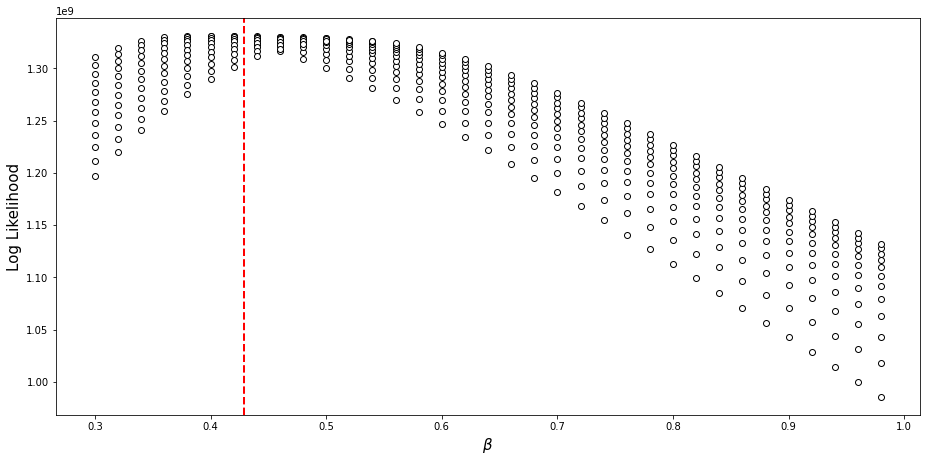

In [64]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.3))

ax.scatter(loglik_df.beta, -loglik_df.value, edgecolor="k", facecolor="white")
#sns.scatterplot(ax=ax, data=loglik_df, x="beta", y="value", hue="gamma", facecolor="white", edgecolor="k")

ax.axvline(x=beta_truth, color="red", linestyle="--", lw=2)
ax.set_xlabel(r"$\beta$", fontsize=15)
ax.set_ylabel("Log Likelihood", fontsize=15)


In [113]:
import statsmodels.api as sm
from scipy import linalg
from math import ceil
import numpy as np
import scipy.stats.chi2 as qchisq

lowess_sm = sm.nonparametric.lowess
x_new   =  np.linspace(min(beta_search), max(beta_search), 1000)
yfitted = lowess_sm(-loglik_df.value, loglik_df.beta, frac=0.1, it=3, return_sorted = False, xvals=x_new)


arg_max = np.argmax(yfitted)
arg_max, x_new[arg_max]

disttance = abs(beta_search-x_new[arg_max])
max_dist  = np.max(disttance)

weights = np.full( len(beta_search), np.nan)
weights = (1-(disttance/max_dist)**3)**3
#weights[included] <- (1-(dist[included]/maxdist)^3)^3

import statsmodels.formula.api as sm
import numpy as np

data  = {"b":beta_search, "a":beta_search**2, "lp":-loglik_df.groupby("beta").mean()[["value"]].values}
model = sm.wls(formula = 'lp ~ a + b', data = data, weights=weights).fit()

b      = model.params["b"]
a      = model.params["a"]

var_a  = model.cov_params().loc["a"]["a"]
var_b  = model.cov_params().loc["a"]["a"]
cov_ab = model.cov_params().loc["a"]["b"]

se_mc_squared    = (1 / (4 * a**2)) * (var_b - (2 * b/a) * cov_ab + (b**2 / a**2) * var_a)
se_stat_squared  = 1/(2*a)
se_total_squared = se_mc_squared + se_stat_squared

#delta            = qchisq(confidence,df=1)
delta            = qchisq.ppf(0.95, 1) * ( a * se_mc_squared + 0.5)

#    quadratic_fit <- lm(lp ~ a + b, weights=weights,
#                        data = data.frame(lp=lp,b=parameter,a=-parameter^2))

NameError: name 'scipy' is not defined

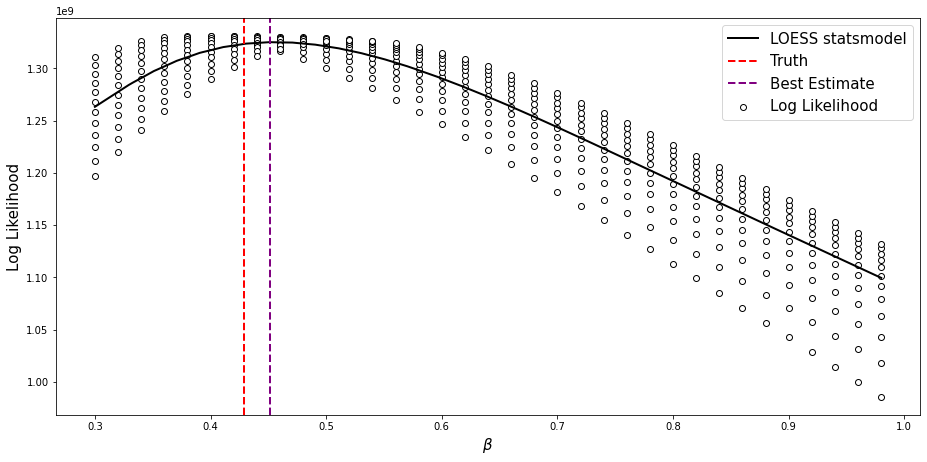

In [72]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.3))

ax.scatter(loglik_df.beta, -loglik_df.value, edgecolor="k", facecolor="white", label="Log Likelihood")
ax.plot(x_new, yfitted, color="black", label = "LOESS statsmodel", lw=2)



ax.axvline(x=beta_truth, color="red", linestyle="--", lw=2, label="Truth")
ax.axvline(x=x_new[arg_max], color="purple", linestyle="--", lw=2, label="Best Estimate")

ax.set_xlabel(r"$\beta$", fontsize=15)
ax.set_ylabel("Log Likelihood", fontsize=15)
ax.legend(fontsize=15)


In [ ]:
R0    = 3
gamma = 1/7
beta  = R0*gamma
N     = 1e8

beta_truth  = beta
gamma_truth = gamma

num_days = 100
x  = [N-0.01*N, 0.01*N, 0, 0.01*N]

x_sol      = np.zeros((num_days, 4))

x_sol[0, :] = x
for d_idx in range(1, num_days):
    x_sol[d_idx, :] = model(x_sol[d_idx-1, :], beta, gamma, N)

x_sol_df = pd.DataFrame(x_sol, columns=["S", "I", "R", "C"]); x_sol_df.index.name="date"